In [30]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('HR_capstone_dataset.csv')

In [31]:
from sklearn.preprocessing import Normalizer
df = pd.get_dummies(df, columns=['Department', 'salary'], dtype=float)


In [32]:
#Разбиваю данные на тренировочные, валидационные и тестовые
from sklearn.model_selection import train_test_split
df_input = df.drop('left', axis=1)
df_output = df['left']

x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size = 0.3, random_state = 42)
x_val, y_val = x_train[:2500], y_train[:2500]
x_train, y_train = x_train[2500:], y_train[2500:]

In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [34]:
x_train, y_train = torch.tensor(x_train.values).float(), torch.tensor(y_train.values).long()
x_test, y_test = torch.tensor(x_test.values).float(), torch.tensor(y_test.values).long()
x_val, y_val = torch.tensor(x_val.values).float(), torch.tensor(y_val.values).long()

In [35]:

x_train_dataset = TensorDataset(x_train, y_train)
x_test_dataset = TensorDataset(x_test, y_test)
x_val_dataset = TensorDataset(x_val, y_val)
x_train_dataset[1]

(tensor([  0.7300,   0.6800,   5.0000, 133.0000,   2.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000]),
 tensor(0))

In [36]:
batch = 32
train_loader = DataLoader(x_train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(x_val_dataset, batch_size=batch, shuffle=True)

In [37]:
#Определяю модель, задаю количество нейронов и слоев, а также фун. активации
class HR_model(nn.Module):
    def __init__(self):
        super(HR_model, self).__init__()
        self.fc1 = nn.Linear(20, 40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, 2)
        self.fc_activation = nn.Tanh()
    def forward(self, x):
        #1
        x = self.fc1(x)
        x = self.fc_activation(x)
        #2
        x = self.fc2(x)
        x = self.fc_activation(x)
        #3
        x = self.fc3(x)
        x = self.fc_activation(x)
        #4
        x = self.fc4(x)

        return x

In [38]:
# !pip install torchinfo
from torchinfo import summary

model = HR_model()
summary(model, [20, 20])

Layer (type:depth-idx)                   Output Shape              Param #
HR_model                                 [20, 2]                   --
├─Linear: 1-1                            [20, 40]                  840
├─Tanh: 1-2                              [20, 40]                  --
├─Linear: 1-3                            [20, 20]                  820
├─Tanh: 1-4                              [20, 20]                  --
├─Linear: 1-5                            [20, 10]                  210
├─Tanh: 1-6                              [20, 10]                  --
├─Linear: 1-7                            [20, 2]                   22
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [39]:
#Критерий ошибки кросс-энтропия, потому что стоит задача классификации
criter = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [40]:
# !pip install pytorch-ignite
from ignite.engine import Engine, _prepare_batch
from ignite.engine import create_supervised_trainer

#Задаю функцию тренировки модели
def process_function(engine, batch):
    model.train()
    x, y = _prepare_batch(batch, device=device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criter(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(process_function)

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
from ignite.engine import Events

# interval = 50

# @trainer.on(Events.ITERATION_COMPLETED)
# def int_training_loss(engine):
#     iter = (engine.state.iteration - 1) % len(train_loader) + 1
#     if iter % interval == 0:
#         print(f'Epoch: [{engine.state.epoch}] Iteration: [{iter}/{len(train_loader)}] Loss: [{engine.state.output}]')


In [43]:
from ignite.engine import create_supervised_evaluator
from ignite.metrics import Loss, Recall, Precision, Accuracy

#Выбираю метрики для оценки модели
metrics = {'avg_loss': Loss(criter),
            'avg_recall': Recall(average=True),
            'avg_accuracy': Accuracy()}

train_eval = create_supervised_evaluator(model, metrics=metrics, device=device)
val_eval = create_supervised_evaluator(model, metrics=metrics, device=device)
test_eval = create_supervised_evaluator(model, metrics=metrics, device=device)

train_history = {'Accuracy': [], 'Loss': []}
val_history = {'Accuracy': [], 'Loss': []}
last_epoch = []

In [44]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, Checkpoint, global_step_from_engine
#Добавляю оценку метрик для тренировки и валидации
@trainer.on(Events.EPOCH_COMPLETED)
def train_reselt(trainer):
    train_eval.run(train_loader)
    metrics = train_eval.state.metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['avg_loss']
    last_epoch.append(0)
    train_history['Accuracy'].append(accuracy)
    train_history['Loss'].append(loss)
    print(f'Результат тренировки: Эпоха[{trainer.state.epoch}] Сред.точность[{accuracy}] Сред.ошибка[{loss}]')

@trainer.on(Events.EPOCH_COMPLETED)
def val_result(trainer):
    val_eval.run(val_loader)
    metrics = val_eval.state.metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['avg_loss']
    val_history['Accuracy'].append(accuracy)
    val_history['Loss'].append(loss)
    print(f'Результат валидации: Эпоха[{trainer.state.epoch}] Сред.точность[{accuracy}] Сред.ошибка[{loss}]')

breaker = EarlyStopping(patience=10, score_function=lambda engine: engine.state.metrics['avg_accuracy'], trainer=trainer)
val_eval.add_event_handler(Events.COMPLETED, breaker)

In [45]:
#Сохраняю 2 лучшие по точности модели
to_save = {'model' : model}
saver = Checkpoint(to_save, './model', n_saved=2,
                  filename_prefix = 'best',
                  score_name='avg_accuracy',
                  global_step_transform = global_step_from_engine(trainer))
val_eval.add_event_handler(Events.COMPLETED, saver)

In [46]:
trainer.run(train_loader, max_epochs=150)

Результат тренировки: Эпоха[1] Сред.точность[75.97199649956245] Сред.ошибка[0.5467786134399613]
Результат валидации: Эпоха[1] Сред.точность[76.92] Сред.ошибка[0.536219873046875]
Результат тренировки: Эпоха[2] Сред.точность[75.69696212026503] Сред.ошибка[0.39086785872648144]
Результат валидации: Эпоха[2] Сред.точность[75.72] Сред.ошибка[0.386779296875]
Результат тренировки: Эпоха[3] Сред.точность[86.08576072009001] Сред.ошибка[0.3123043578689524]
Результат валидации: Эпоха[3] Сред.точность[85.92] Сред.ошибка[0.320387060546875]
Результат тренировки: Эпоха[4] Сред.точность[88.79859982497813] Сред.ошибка[0.28042171042864733]
Результат валидации: Эпоха[4] Сред.точность[88.8] Сред.ошибка[0.2934483154296875]
Результат тренировки: Эпоха[5] Сред.точность[89.54869358669833] Сред.ошибка[0.26863175401808037]
Результат валидации: Эпоха[5] Сред.точность[89.03999999999999] Сред.ошибка[0.2824504638671875]
Результат тренировки: Эпоха[6] Сред.точность[88.56107013376672] Сред.ошибка[0.26150250592847546]


2024-05-02 14:43:04,374 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Результат валидации: Эпоха[50] Сред.точность[94.24] Сред.ошибка[0.16247509765625]


State:
	iteration: 12500
	epoch: 50
	epoch_length: 250
	max_epochs: 150
	output: 0.06321067363023758
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

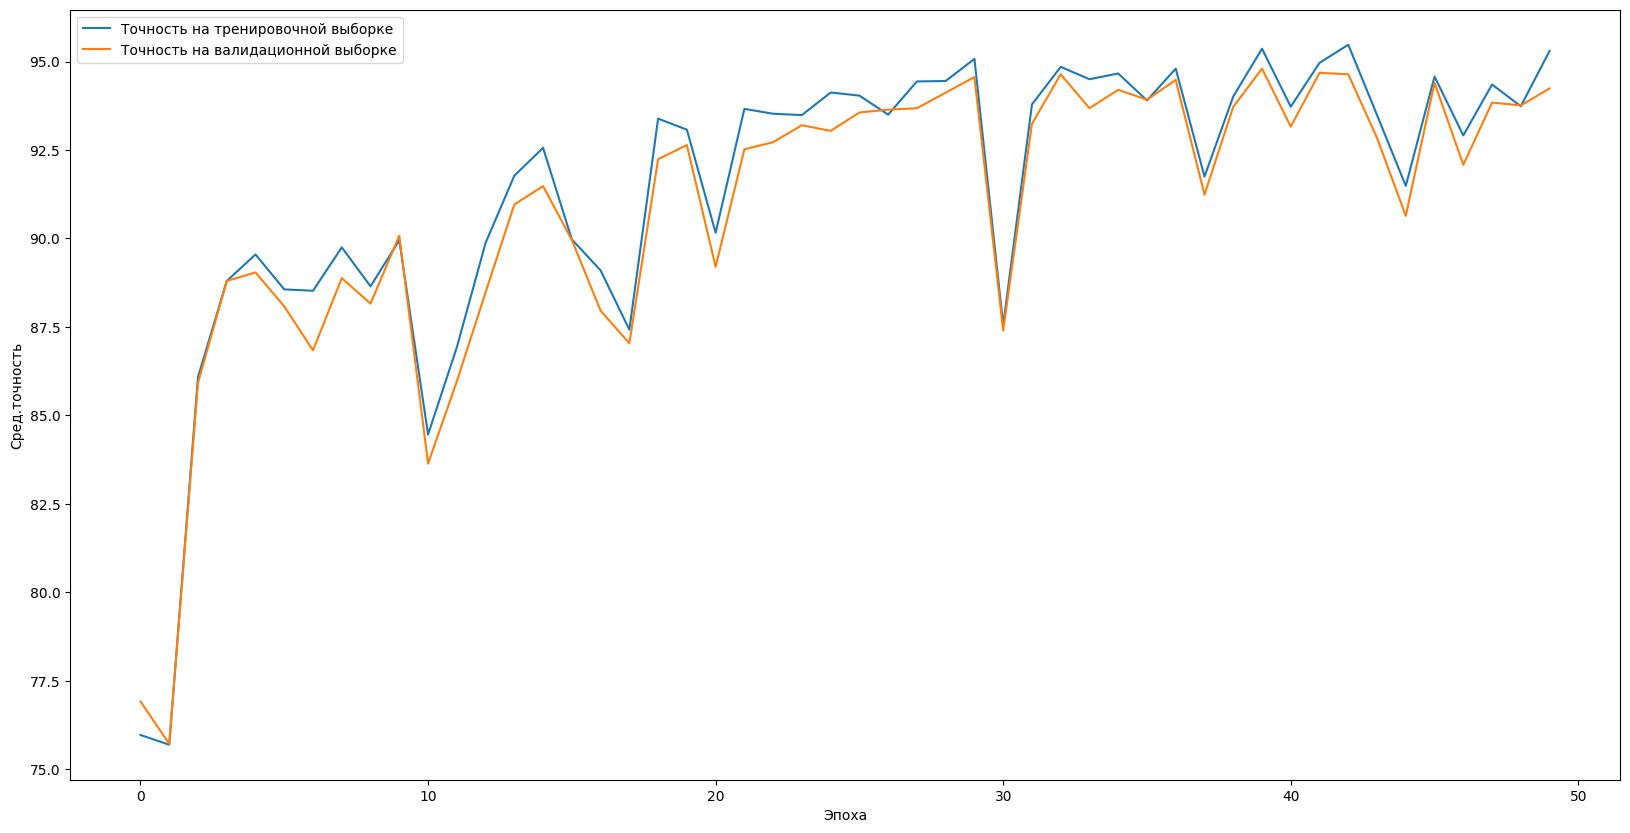

In [47]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,10)
plt.plot(train_history['Accuracy'], label='Точность на тренировочной выборке')
plt.plot(val_history['Accuracy'], label='Точность на валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Сред.точность')
plt.legend()
plt.show()


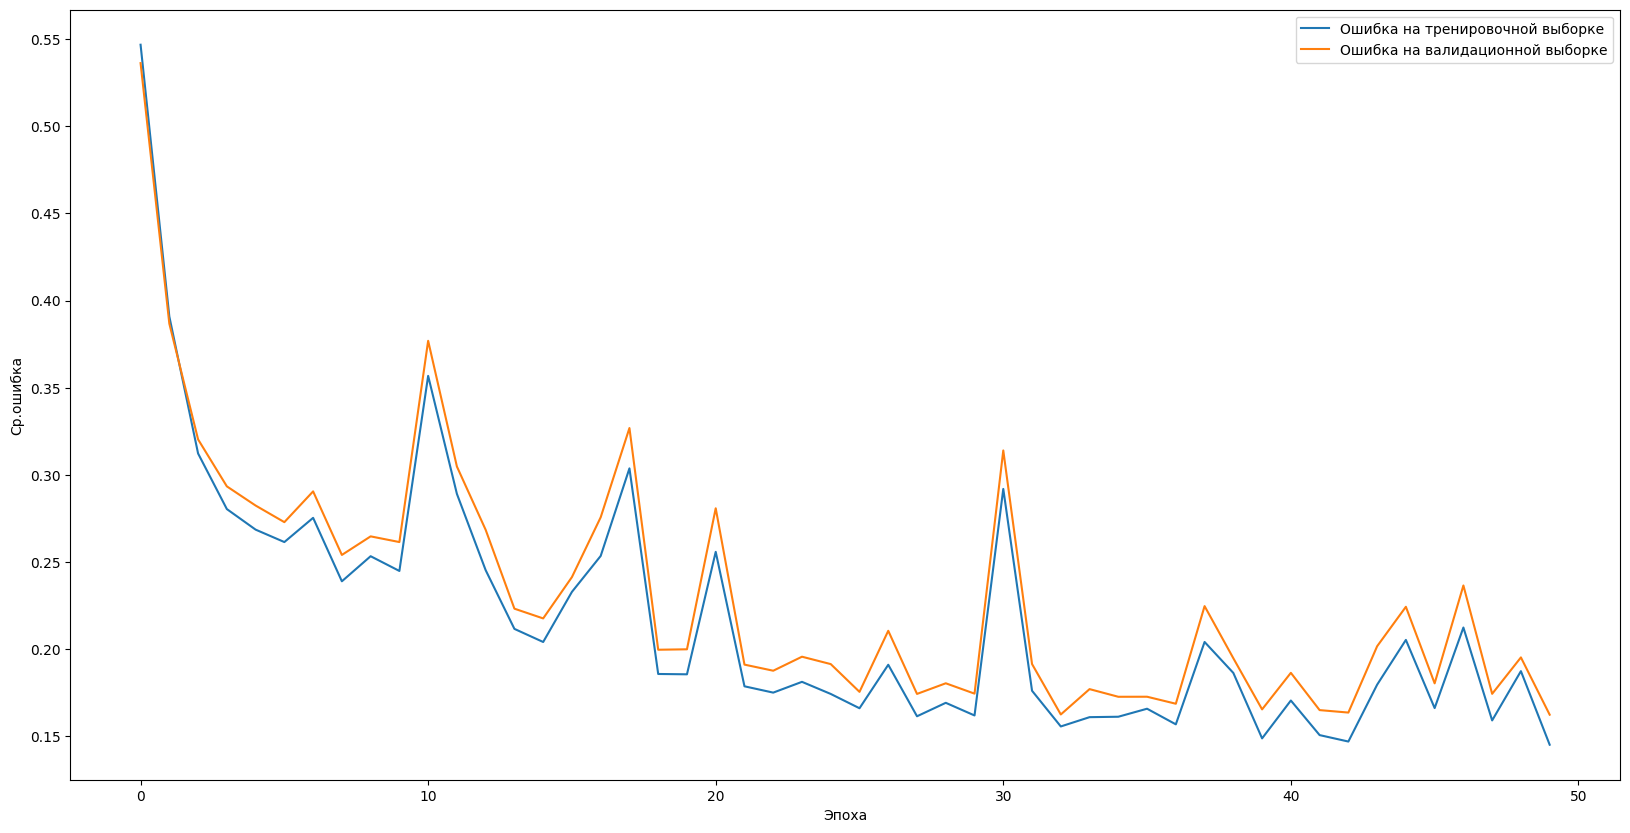

In [48]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(train_history['Loss'], label='Ошибка на тренировочной выборке')
plt.plot(val_history['Loss'], label='Ошибка на валидационной выборке')
plt.xlabel('Эпоха')
plt.ylabel('Ср.ошибка')
plt.legend()
plt.show()

In [49]:
#Загрузка лучшей модели
def fetch_last_model_filename(model_save_patch):
    import os
    chekpoints_files = os.listdir(model_save_patch)
    chekpoints_files = [f for f in chekpoints_files if '.pt' in f]
    chekpoint_iter = [int(x.split('_')[2].split('.')[0]) for x in chekpoints_files]
    last_idx = np.array(chekpoint_iter).argmax()
    return os.path.join(model_save_patch, chekpoints_files[last_idx])
model.load_state_dict(torch.load(fetch_last_model_filename('model')))
print('Модель загружена')

Модель загружена


In [50]:
#Определяю количество ошибок в предсказании тестовой выборки (4500 значений)
from torch import squeeze
test_loader = DataLoader(x_test_dataset, shuffle=True)
model.to(device)
count_loss = 0
for batch in test_loader:
    x_test, y_test = _prepare_batch(batch, device=device)
    predict = model(x_test)
    predict = predict.cpu()
    predict = predict.data.numpy().squeeze()
    y_test = y_test.cpu()
    y_test = y_test.data.numpy().squeeze()
    if np.argmax(predict) != y_test:
        count_loss += 1
print('Кол-во неправильных предсказаний [{}]\nОшибка на тестовой выборке [{:.4f}]'.format(count_loss, count_loss/len(test_loader)))

Кол-во неправильных предсказаний [258]
Ошибка на тестовой выборке [0.0573]
